In [56]:
import pandas as pd
import numpy as np
import tqdm
import datetime
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
pd.set_option("max.columns", None)

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
df = pd.read_csv("raw_data_com_labels.csv",index_col=0)
df = df[df['y'].notnull()]
df.head()

,uploader,title,y,upload_date,user,view_count,like_count,dislike_count,thumbnail,width,height,categories,tags,channel_url,description
0,Yanjun Qi,S0-Introduction-Module3: Deep Learning and AI ...,0.0,2020-08-25,UCHMYETgeGbNHVHLidZSV8BQ,22,NaN,NaN,https://i.ytimg.com/vi/LkPmTGw1jqo/hqdefault.j...,1280,672,Science & Technology,Machine Learning,http://www.youtube.com/channel/UCHMYETgeGbNHVH...,Course Web: \nhttps://qiyanjun.github.io/2020f...
1,Ciência dos Dados,Machine Learning no Ensino Médio,0.0,2020-08-25,UCd3ThZLzVDDnKSZMsbK0icg,3,NaN,NaN,https://i.ytimg.com/vi_webp/R_gBq8IfwJc/maxres...,1920,1080,Education,machine learning|data science,http://www.youtube.com/channel/UCd3ThZLzVDDnKS...,"A matemática, sempre ela....\n\nDe uma maneira..."
2,iKennyHD,NBA LIVE 22: EA COULD USE DEEP MACHINE LEARNIN...,0.0,2020-08-25,KennyCallOfDuty,47,NaN,NaN,https://i.ytimg.com/vi/Tix2xon9MSs/maxresdefau...,1920,1080,Gaming,iKennyHD|nba live20|nba live 20|nba 2k20|live2...,http://www.youtube.com/channel/UCGMtoj9V9Go_im...,Wanna Donate? paypal.me/iKennyYT is where you ...
3,Amazon Web Services,Amazon Aurora Machine Learning – SageMaker Int...,0.0,2020-08-25,AmazonWebServices,335,NaN,NaN,https://i.ytimg.com/vi/w-2ip78NxAw/maxresdefau...,1920,1080,Science & Technology,AWS|Amazon Web Services|Cloud|AWS Cloud|Cloud ...,http://www.youtube.com/channel/UCd6MoB9NC6uYN2...,Learn how you can turn relational data into in...
4,"GMRIT, Rajam, AP",Machine Learning and Deep Learning Implementat...,1.0,2020-08-25,UC8g7hz4oXFzXNryt8h1gRPw,1486,NaN,NaN,https://i.ytimg.com/vi/f6XIY_M7FlA/hqdefault.j...,1280,720,People & Blogs,NaN,http://www.youtube.com/channel/UC8g7hz4oXFzXNr...,Resource Person\nMr.S.Aravinth Seshadri\nCerti...


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 499
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   uploader       499 non-null    object 
 1   title          499 non-null    object 
 2   y              499 non-null    float64
 3   upload_date    499 non-null    object 
 4   user           499 non-null    object 
 5   view_count     499 non-null    int64  
 6   like_count     0 non-null      float64
 7   dislike_count  0 non-null      float64
 8   thumbnail      499 non-null    object 
 9   width          499 non-null    int64  
 10  height         499 non-null    int64  
 11  categories     499 non-null    object 
 12  tags           424 non-null    object 
 13  channel_url    499 non-null    object 
 14  description    499 non-null    object 
dtypes: float64(3), int64(3), object(9)
memory usage: 62.4+ KB


In [22]:
df_limpo = pd.DataFrame(index=df.index)

## 1. Limpeza da Data

In [23]:
df_limpo['date'] = pd.to_datetime(df['upload_date'])

## 2. Limpeza de views

In [24]:
views = df['view_count'].fillna(0)
df_limpo['views'] = views

### 3. Features

In [25]:
features = pd.DataFrame(index=df_limpo.index)
y = df['y'].copy()

In [26]:
today = datetime.datetime.today().strftime("%Y-%m-%d")
today

'2020-08-26'

In [27]:
features['tempo_desde_pub'] = (pd.to_datetime(today) -  df_limpo['date']) / np.timedelta64(1, 'D')
features['views'] = df_limpo['views']
features['views_por_dia'] = (features['views'] / features['tempo_desde_pub']).round(3)
features.drop(['tempo_desde_pub'], axis=1, inplace=True)

In [36]:
features.sample(10)

,views,views_por_dia
494,145182,207.700
232,243,2.170
498,243364,345.197
283,10401,52.530
355,28707,70.533
400,21298,48.849
178,54133,762.437
365,869249,2007.503
435,32759,51.916
373,12258,27.362


In [37]:
df_limpo['date'].min(), df_limpo['date'].max()

(Timestamp('2018-09-20 00:00:00'), Timestamp('2020-08-25 00:00:00'))

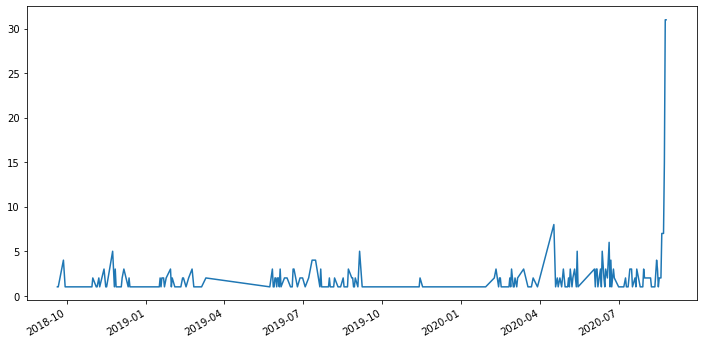

In [38]:
df_limpo['date'].value_counts().plot(figsize=(12,6))

In [44]:
Xtrain, Xval = features[df_limpo['date'] <= '2020-03-10'], features[df_limpo['date'] > '2020-03-10']
ytrain, yval = y[df_limpo['date'] <= '2020-03-10'], y[df_limpo['date'] > '2020-03-10']
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((244, 2), (255, 2), (244,), (255,))

In [47]:
mdl = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight='balanced')
mdl.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [3]:
p = mdl.predict_proba(Xval)[:,1]

NameError: name 'mdl' is not defined

In [52]:
# De todos que são positivos quantos meu modelo previu como positivos?
metrics.average_precision_score(yval, p)

0.38286935216988094

In [53]:
metrics.roc_auc_score(yval, p)

0.5191776315789474

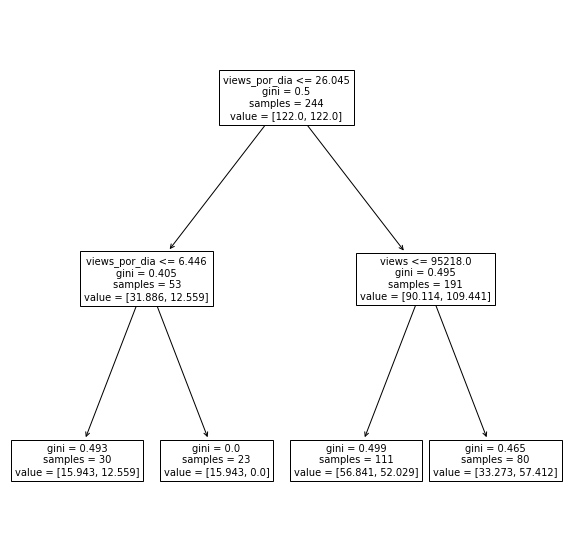

In [58]:
# plotando arvore
fig, ax = pylab.subplots(1,1, figsize=(10,10))
plot_tree(mdl, ax=ax, feature_names=Xtrain.columns)

plt.show()